# ANLY590 - Final Project

# Mask R-CNN Based Vehicle Detection and Segmentation

### Group Member: Zhe Zhou, Jiaxuan Sun, Jen Wang


In [1]:
%load_ext autoreload
import os
os.getcwd()

'C:\\Users\\zhouz\\Projects\\590pj'

In [2]:
import os
import sys
import json
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path


In [3]:
## check my local CUDA environment

import tensorflow as tf

tf.test.is_gpu_available()

True

# Import Matterport's "mrcnn" libraries
we are using Matterport's Mask_RCNN libraries: https://github.com/matterport/Mask_RCNN



In [4]:
# Have to clone the repo and place it under the root directory
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = './Mask_RCNN/'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuration
Define configurations for training on the box_dataset_synthetic dataset.


In [7]:
class CocoSynthConfig(Config):
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "Car_detection"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 7 box types

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1200

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CocoSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [8]:
class CocoLikeDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):

        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets


In [9]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('./datasets/train/coco_instances.json',
                        './datasets/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('./datasets/val/coco_instances.json',
                      './datasets/val/images')
dataset_val.prepare()



## Display a few images from the train and val datasets
This will just make sure everything is set up correctly

Displaying examples from training dataset:


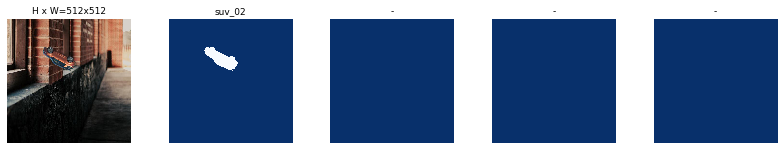

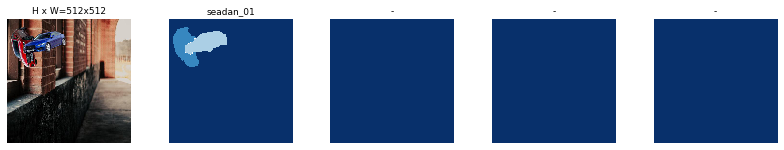

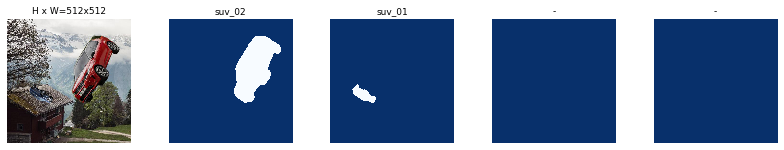

Displaying examples from validation dataset:


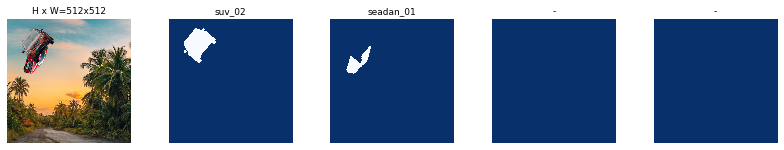

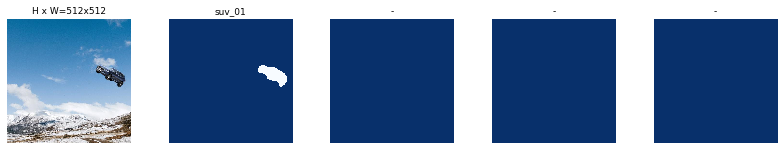

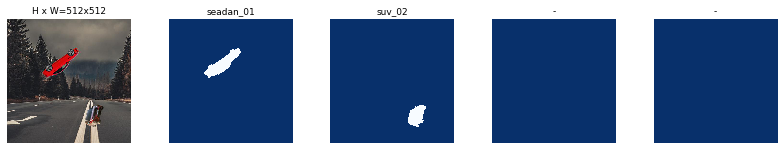

In [10]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Training


In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
init_with = "coco"  

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":

    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./Mask_RCNN/logs\car_detection20191129T1340\mask_rcnn_car_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_

C:\Users\zhouz\Anaconda3\envs\opencvenv3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
1200/1200 [==============================] - 480s 400ms/step - loss: 1.3626 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.5896 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.2383 - val_loss: 2.6080 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.4308 - val_mrcnn_class_loss: 1.5509 - val_mrcnn_bbox_loss: 0.2021 - val_mrcnn_mask_loss: 0.4197
Epoch 2/4
1200/1200 [==============================] - 466s 388ms/step - loss: 0.9041 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.1554 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1516 - val_loss: 2.8650 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.4966 - val_mrcnn_class_loss: 1.6048 - val_mrcnn_bbox_loss: 0.2442 - val_mrcnn_mask_loss: 0.5155
Epoch 3/4
1200/1200 [==============================] - 465s 387ms/step - loss: 0.7913 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1337 - val_loss: 3.0840 - val

In [14]:
# Fine tune all layers

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: ./Mask_RCNN/logs\car_detection20191129T1340\mask_rcnn_car_detection_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_

C:\Users\zhouz\Anaconda3\envs\opencvenv3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 5/8
1200/1200 [==============================] - 613s 511ms/step - loss: 0.6184 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.3147 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1175 - val_loss: 3.3445 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.1698 - val_mrcnn_class_loss: 2.1643 - val_mrcnn_bbox_loss: 0.1710 - val_mrcnn_mask_loss: 0.8384
Epoch 6/8
1200/1200 [==============================] - 594s 495ms/step - loss: 0.5766 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2948 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1141 - val_loss: 3.1295 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.1994 - val_mrcnn_class_loss: 1.9348 - val_mrcnn_bbox_loss: 0.1564 - val_mrcnn_mask_loss: 0.8365
Epoch 7/8
1200/1200 [==============================] - 593s 494ms/step - loss: 0.5305 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2587 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1136 - val_loss: 3.4324 - val

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [11]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [12]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Load Trained Weights
Note: The code is set to find_last() by default, but you can also point the model to a specific pretrained weights file if you use line 3 instead of line 4.

In [22]:
# Get path to saved weights
# Either set a specific path or find last trained weights

#model_path = model.find_last()
model_path = './Mask_RCNN/logs/car_detection20191129T1340/mask_rcnn_car_detection_0008.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./Mask_RCNN/logs/car_detection20191129T1340/mask_rcnn_car_detection_0008.h5
Re-starting from epoch 8


In [28]:
model_path

'./Mask_RCNN/logs\\car_detection20191129T0137\\mask_rcnn_car_detection_0008.h5'

# Image Inference
Run model.detect() on real images.



Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


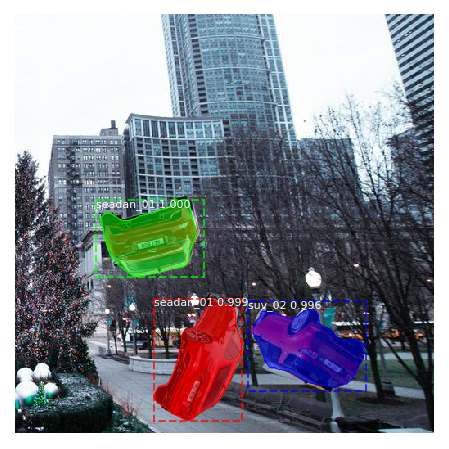

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


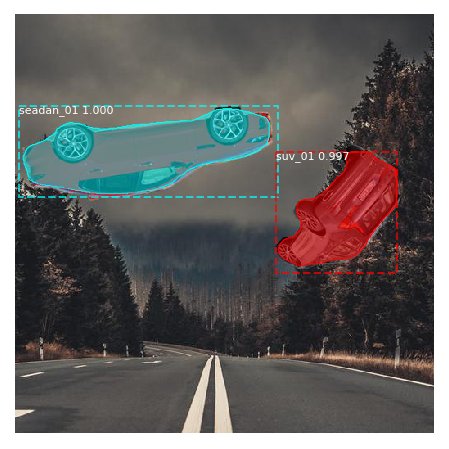

Processing 1 images
image                    shape: (281, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


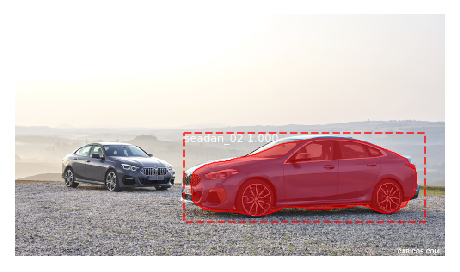

Processing 1 images
image                    shape: (281, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


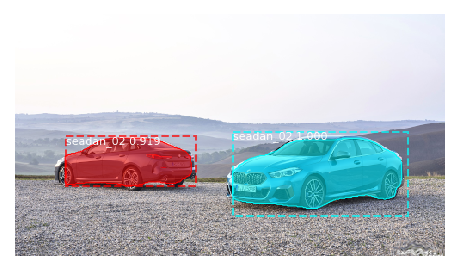

Processing 1 images
image                    shape: (281, 500, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


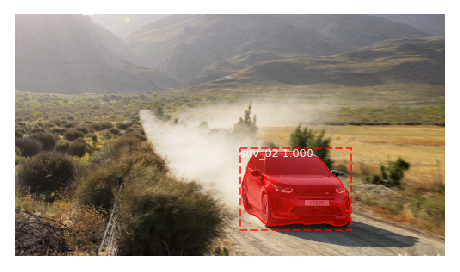

Processing 1 images
image                    shape: (526, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


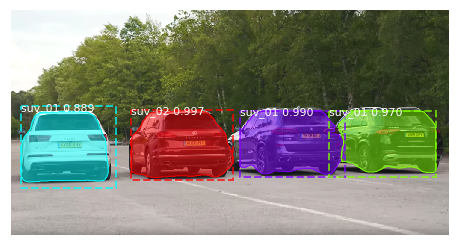

In [23]:
import skimage

real_test_dir = './datasets/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(8,8))

<br>

# Check weights distribution on each layer

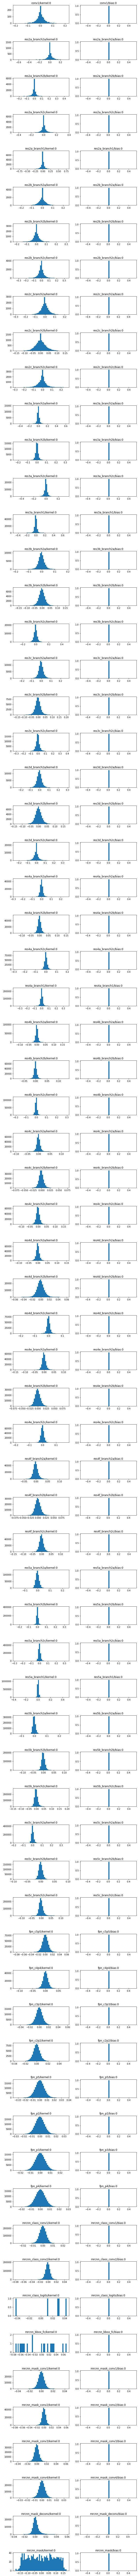

In [24]:

import matplotlib.pyplot as plt
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)

In [29]:
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res2a_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10001  float32
res4w_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   27.64236  float32
rpn_bbox                 shape: (1, 65472, 4)         min:   -8.77186  max:   56.55510  float32
roi                      shape: (1, 500, 4)           min:    0.00000  max:    1.00000  float32


<br>

# sample feature visualization

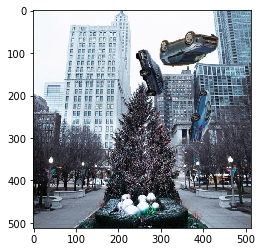

In [30]:
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

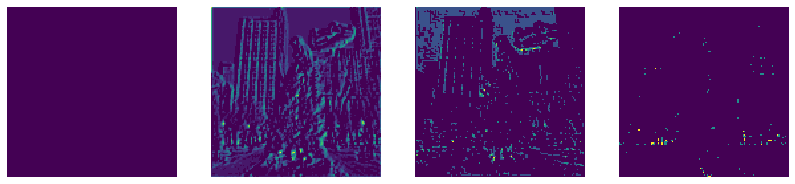

In [31]:
from mrcnn.visualize import display_images
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))